In [1]:
import os

import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import random
seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
import eli5

In [2]:
%%time
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')

# train_pred = pd.read_csv('./simple_xgboost_cv.csv', index_col='TransactionID')
# test_pred = pd.read_csv('./simple_xgboost_pred.csv', index_col='TransactionID')
# test_pred['pred'] = (test_pred['pred1'] + test_pred['pred2'] + test_pred['pred3'] )/3
# del test_pred['pred1'],test_pred['pred2'],test_pred['pred3']

# train_f2 = pd.read_csv('../input/f2_train.csv', index_col='TransactionID')
# del train_f2['isFraud']
# test_f2 = pd.read_csv('../input/f2_test.csv', index_col='TransactionID')

sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

CPU times: user 49.9 s, sys: 4.89 s, total: 54.8 s
Wall time: 54.8 s


In [3]:
train_transaction['hour'] = train_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
test_transaction['hour'] = test_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
train_transaction['weekday'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
test_transaction['weekday'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)

In [4]:
train_test = train_transaction.append(test_transaction)
for col in "ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9".split(","):
    col_count = train_test.groupby(col)['TransactionDT'].count()
    train_transaction[col+'_count'] = train_transaction[col].map(col_count)
    test_transaction[col+'_count'] = test_transaction[col].map(col_count)
    s = set(train_transaction[col].tolist())
#     print(col,test_transaction[col].map(lambda x:0 if x in s else 1).sum())


for col in "card1,card2,card5,addr1,addr2".split(","):
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
    col_count1 = train_test[train_test['C5'] == 0].groupby(col)['C5'].count()
    col_count2 = train_test[train_test['C5'] != 0].groupby(col)['C5'].count()
    train_transaction[col+'_C5count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
    test_transaction[col+'_C5count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
#     col_count1 = train_test[train_test['C14'] == 0].groupby(col)['C14'].count()
#     col_count2 = train_test[train_test['C14'] != 0].groupby(col)['C14'].count()
#     train_transaction[col+'_C14count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
#     test_transaction[col+'_C14count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
# for col in "card1,card2,card3,card5,card6,addr1,addr2,C1,C2".split(","):
#     col_count = train_test.groupby(col)['TransactionDT'].first()
#     train_transaction[col+'_first_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_first_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
#     col_count = train_test.groupby(col)['TransactionDT'].last()
#     train_transaction[col+'_last_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_last_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
    
#     print(col,len(set(train_transaction[col].tolist())),len(set(test_transaction[col].tolist())),len(set(test_transaction[col].tolist()) - set(train_transaction[col].tolist())))

# card1 13553 13244 3538
# card2 9433 9151 8655
# card3 1679 3117 3021
# card4 5 5 0
# card5 4378 4649 4566
# card6 5 4 0
# addr1 66038 65901 65718
# addr2 65780 65681 65628
# C1 1657 1177 533
# C2 1216 1126 571
# C3 27 34 8
# C4 1260 731 275
# C5 319 356 37
# C6 1328 837 249
# C7 1103 521 235
# C8 1253 445 169
# C9 205 357 158
# C10 1231 459 159
# C11 1476 940 361
# C12 1199 666 334
# C13 1597 5817 4842
# C14 1108 572 45


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [7]:
# train_identity['has_identity'] = 1
# test_identity['has_identity'] = 1
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
# train['has_identity'] = train['has_identity'].fillna(0)
# test['has_identity'] = test['has_identity'].fillna(0)
# train = train.merge(train_f2, how='left', left_index=True, right_index=True)
# test = test.merge(test_f2, how='left', left_index=True, right_index=True)
train[train['isFraud'] == 1].to_csv('./fraud.csv')
print(train.shape)
print(test.shape)

test['isFraud'] = 0
y_train = train['isFraud'].copy()
y_test = test['isFraud'].copy()
del train_identity, test_identity
# del train_transaction, test_transaction
# del train['card1'],test['card1'],train['card2'],test['card2']
# del train['TransactionDT'],test['TransactionDT']

# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_test = test.drop('isFraud', axis=1)

# del train, test

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   

(590540, 477)
(506691, 476)


In [8]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

debug = True
if debug:
    split_pos = X_train.shape[0]*4//5
    y_test = y_train.iloc[split_pos:]
    y_train = y_train.iloc[:split_pos]
    X_test = X_train.iloc[split_pos:,:]
    X_train = X_train.iloc[:split_pos,:]

Memory usage of dataframe is 2169.11 MB
Memory usage after optimization is: 630.49 MB
Decreased by 70.9%
Memory usage of dataframe is 1863.96 MB
Memory usage after optimization is: 551.54 MB
Decreased by 70.4%
CPU times: user 2min 33s, sys: 6min 58s, total: 9min 31s
Wall time: 9min 31s


In [9]:
%%time

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
X_test_pred = pd.DataFrame(index = X_test.index)
X_train_pred = pd.DataFrame(index = X_train.index)
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
    i+=1
    clf = xgb.XGBClassifier(
        n_estimators=700,
        max_depth=9,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method='gpu_hist'
    )
    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds+= clf.predict_proba(X_test)[:,1] / folds
    X_test_pred['pred'+str(i)] = clf.predict_proba(X_test)[:,1]
    if debug:    
        print("debug:",roc_auc_score(y_test, clf.predict_proba(X_test)[:,1] / folds))   

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds))  

X_train_pred['pred'] = y_oof
X_train_pred['isFraud'] = y_train
X_train_pred['card1'] = X_train['card1']
X_train_pred['card2'] = X_train['card2']
X_train_pred['TransactionAmt'] = X_train['TransactionAmt']
X_train_pred.to_csv('simple_xgboost_cv2.csv')
X_test_pred['card1'] = X_test['card1']
X_test_pred['card2'] = X_test['card2']
X_test_pred['TransactionAmt'] = X_test['TransactionAmt']
X_test_pred.to_csv('simple_xgboost_pred2.csv')

ROC AUC 0.966235329912688
debug: 0.9262183093460682
ROC AUC 0.9664369393080817
debug: 0.9282358914621156
ROC AUC 0.9673849823814376
debug: 0.923463808009797
debug: 0.931190208401744
CPU times: user 3min 39s, sys: 2min 9s, total: 5min 48s
Wall time: 6min 4s


In [10]:
temp = X_train.loc[2987367:2987368]
temp2 = X_train.loc[2987366:2987367]
temp11 = train.loc[2987367:2987368]
temp22 = train.loc[2987366:2987367]
temp3 = temp.copy()
# print(temp.values)
# clf.predict_proba(X_train.loc[2990196:2990197])[:,1]
print(X_train.V70.value_counts())
for i in range(X_train.shape[1]-1,-1,-1):
    
    temp3.iloc[0,i] = temp2.iloc[0,i]
    print(i,X_train.columns[i],temp.iloc[0,i],temp2.iloc[0,i],temp11[X_train.columns[i]].iloc[0],temp22[X_train.columns[i]].iloc[0],clf.predict_proba(temp3)[:,1])
    
# C5 C14 V70

0.0    251774
1.0    144743
2.0      7687
3.0      1021
4.0       186
5.0       130
6.0         1
Name: V70, dtype: int64
475 DeviceInfo 2767 2693 rv:52.0 iOS Device [0.9940832  0.02725892]
474 DeviceType 0 1 desktop mobile [0.99518186 0.02725892]
473 id_38 0 1 F T [0.99518186 0.02725892]
472 id_37 1 1 T T [0.99518186 0.02725892]
471 id_36 0 0 F F [0.99518186 0.02725892]
470 id_35 1 1 T T [0.99518186 0.02725892]
469 id_34 3 2 match_status:2 match_status:1 [0.99516726 0.02725892]
468 id_33 123 243 1440x900 2048x1536 [0.99467707 0.02725892]
467 id_32 24.0 32.0 24.0 32.0 [0.9953265  0.02725892]
466 id_31 89 130 firefox mobile safari 11.0 [0.99563855 0.02725892]
465 id_30 49 67 Windows 10 iOS 11.0.3 [0.9961125  0.02725892]
464 id_29 0 0 Found Found [0.9961125  0.02725892]
463 id_28 0 0 Found Found [0.9961125  0.02725892]
462 id_27 2 2 nan nan [0.9961125  0.02725892]
461 id_26 nan nan nan nan [0.9961125  0.02725892]
460 id_25 nan nan nan nan [0.9961125  0.02725892]
459 id_24 nan nan nan nan

330 V278 475.0 0.0 475.0 0.0 [0.99776566 0.02725892]
329 V277 475.0 0.0 475.0 0.0 [0.99745697 0.02725892]
328 V276 475.0 0.0 475.0 0.0 [0.9974819  0.02725892]
327 V275 250.0 0.0 250.0 0.0 [0.99731076 0.02725892]
326 V274 250.0 0.0 250.0 0.0 [0.99710137 0.02725892]
325 V273 250.0 0.0 250.0 0.0 [0.9969406  0.02725892]
324 V272 0.0 0.0 0.0 0.0 [0.9969406  0.02725892]
323 V271 0.0 0.0 0.0 0.0 [0.9969406  0.02725892]
322 V270 0.0 0.0 0.0 0.0 [0.9969406  0.02725892]
321 V269 0.0 0.0 0.0 0.0 [0.9969406  0.02725892]
320 V268 0.0 0.0 0.0 0.0 [0.9969406  0.02725892]
319 V267 0.0 0.0 0.0 0.0 [0.9969406  0.02725892]
318 V266 0.0 0.0 0.0 0.0 [0.9969406  0.02725892]
317 V265 725.0 0.0 725.0 0.0 [0.99602723 0.02725892]
316 V264 725.0 0.0 725.0 0.0 [0.9958165  0.02725892]
315 V263 725.0 0.0 725.0 0.0 [0.9958165  0.02725892]
314 V262 4.0 1.0 4.0 1.0 [0.99592125 0.02725892]
313 V261 4.0 1.0 4.0 1.0 [0.9958689  0.02725892]
312 V260 4.0 1.0 4.0 1.0 [0.9958689  0.02725892]
311 V259 0.0 1.0 0.0 1.0 [0.99586

161 V109 1.0 1.0 1.0 1.0 [0.9916883  0.02725892]
160 V108 1.0 1.0 1.0 1.0 [0.9916883  0.02725892]
159 V107 1.0 1.0 1.0 1.0 [0.9916883  0.02725892]
158 V106 0.0 0.0 0.0 0.0 [0.9916883  0.02725892]
157 V105 0.0 0.0 0.0 0.0 [0.9916883  0.02725892]
156 V104 0.0 0.0 0.0 0.0 [0.9916883  0.02725892]
155 V103 0.0 0.0 0.0 0.0 [0.9916883  0.02725892]
154 V102 0.0 0.0 0.0 0.0 [0.9916883  0.02725892]
153 V101 0.0 0.0 0.0 0.0 [0.9916883  0.02725892]
152 V100 0.0 0.0 0.0 0.0 [0.9916883  0.02725892]
151 V99 0.0 1.0 0.0 1.0 [0.9916883  0.02725892]
150 V98 0.0 0.0 0.0 0.0 [0.9916883  0.02725892]
149 V97 0.0 0.0 0.0 0.0 [0.9916883  0.02725892]
148 V96 0.0 1.0 0.0 1.0 [0.9916093  0.02725892]
147 V95 0.0 0.0 0.0 0.0 [0.9916093  0.02725892]
146 V94 nan 0.0 nan 0.0 [0.9916093  0.02725892]
145 V93 nan 0.0 nan 0.0 [0.9916093  0.02725892]
144 V92 nan 0.0 nan 0.0 [0.9916093  0.02725892]
143 V91 nan 0.0 nan 0.0 [0.9916093  0.02725892]
142 V90 nan 0.0 nan 0.0 [0.9916093  0.02725892]
141 V89 nan 0.0 nan 0.0 [0.991

In [11]:
from sklearn.feature_extraction import DictVectorizer
# print(eli5.explain_prediction_xgboost(clf,X_test.iloc[0,:], vec = vec))
eli5.show_weights(clf)
# print(res.data)
# eli5.explain_prediction(clf,X_test.iloc[10,:])
# eli5.show_prediction(clf, X_train.iloc[10:11,:],show_feature_values=True)


Weight,Feature
0.1178,V258
0.0232,V70
0.0224,V257
0.0221,V244
0.0180,V189
0.0170,V91
0.0142,C1_count
0.0140,V294
0.0110,C4_count
0.0107,C14


In [12]:
import lightgbm as lgb
# feat_col = [x for x in X_train.columns if x in ['stationID','hour', 'min', 'minandhour','num_neighboor', 'station_time0', 'station_time1',
#        'station_time2', 'station_time3', 'station_pos', 'station_pos2',  'datediff',
#        'station_time_diff_0', 'station_time_diff_1', 'station_time_diff_2',
#        'station_time_diff_3', 'th', 'tl', 'cloud', 'rain1','line0','line0b','line1','line2',
#        'rain2', 'cloud2', 'cloud3', 'sun', 'weekday', 'weekend','type','railway','busstation'] or x.startswith("svd") or x.startswith("w2v") or x.startswith("poi")]
cate = [x for x in X_train.columns if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card") or 
                                       x.endswith("domain") or x.startswith("Device")) and not x.endswith("count") ]
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'auc',
          'max_depth': 9,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.1,
          'lambda_l2': 0.01,
#           'min_child_weight': 30,
          'data_random_seed': 17}
early_stop = 500
verbose_eval = 30
num_rounds = 2000
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds2 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test, label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds2+= model.predict(X_test) / folds
    
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_tr.columns
    fold_importance_df["importance"] = model.feature_importance()
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    if debug:    
        print("debug:",roc_auc_score(y_test, model.predict(X_test) / folds))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5))  




['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo']


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[30]	valid_0's auc: 0.913825	valid_1's auc: 0.880375
[60]	valid_0's auc: 0.932777	valid_1's auc: 0.890666
[90]	valid_0's auc: 0.941112	valid_1's auc: 0.896137
[120]	valid_0's auc: 0.946126	valid_1's auc: 0.900444
[150]	valid_0's auc: 0.949452	valid_1's auc: 0.901942
[180]	valid_0's auc: 0.951965	valid_1's auc: 0.903403
[210]	valid_0's auc: 0.95404	valid_1's auc: 0.904405
[240]	valid_0's auc: 0.955612	valid_1's auc: 0.905499
[270]	valid_0's auc: 0.956815	valid_1's auc: 0.906224
[300]	valid_0's auc: 0.957753	valid_1's auc: 0.907345
[330]	valid_0's auc: 0.958585	valid_1's auc: 0.908321
[360]	valid_0's auc: 0.959515	valid_1's auc: 0.908624
[390]	valid_0's auc: 0.960216	valid_1's auc: 0.908955
[420]	valid_0's auc: 0.961134	valid_1's auc: 0.909533
[450]	valid_0's auc: 0.961789	valid_1's auc: 0.910009
[480]	valid_0's auc: 0.962149	valid_1's auc: 0.910295
[510]	valid_0's auc: 0.962713	valid_1's auc: 0.910118
[540]	valid_0's auc: 0.

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[30]	valid_0's auc: 0.912647	valid_1's auc: 0.877229
[60]	valid_0's auc: 0.930007	valid_1's auc: 0.889421
[90]	valid_0's auc: 0.939632	valid_1's auc: 0.89548
[120]	valid_0's auc: 0.944177	valid_1's auc: 0.897977
[150]	valid_0's auc: 0.948286	valid_1's auc: 0.899847
[180]	valid_0's auc: 0.951242	valid_1's auc: 0.901272
[210]	valid_0's auc: 0.953376	valid_1's auc: 0.902816
[240]	valid_0's auc: 0.955069	valid_1's auc: 0.904072
[270]	valid_0's auc: 0.956442	valid_1's auc: 0.904633
[300]	valid_0's auc: 0.957701	valid_1's auc: 0.904885
[330]	valid_0's auc: 0.958563	valid_1's auc: 0.905673
[360]	valid_0's auc: 0.959319	valid_1's auc: 0.906218
[390]	valid_0's auc: 0.960224	valid_1's auc: 0.906465
[420]	valid_0's auc: 0.960763	valid_1's auc: 0.906265
[450]	valid_0's auc: 0.961458	valid_1's auc: 0.906462
[480]	valid_0's auc: 0.962172	valid_1's auc: 0.907209
[510]	valid_0's auc: 0.962731	valid_1's auc: 0.907434
[540]	valid_0's auc: 0.

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[30]	valid_0's auc: 0.916347	valid_1's auc: 0.876532
[60]	valid_0's auc: 0.934446	valid_1's auc: 0.888091
[90]	valid_0's auc: 0.944423	valid_1's auc: 0.895972
[120]	valid_0's auc: 0.949881	valid_1's auc: 0.899139
[150]	valid_0's auc: 0.952967	valid_1's auc: 0.901742
[180]	valid_0's auc: 0.955271	valid_1's auc: 0.902573
[240]	valid_0's auc: 0.959071	valid_1's auc: 0.904952
[270]	valid_0's auc: 0.960314	valid_1's auc: 0.905923
[300]	valid_0's auc: 0.961569	valid_1's auc: 0.906855
[330]	valid_0's auc: 0.962348	valid_1's auc: 0.907081
[360]	valid_0's auc: 0.962999	valid_1's auc: 0.907511
[390]	valid_0's auc: 0.963505	valid_1's auc: 0.907928
[420]	valid_0's auc: 0.964202	valid_1's auc: 0.908239
[450]	valid_0's auc: 0.965022	valid_1's auc: 0.909114
[480]	valid_0's auc: 0.965606	valid_1's auc: 0.909514
[510]	valid_0's auc: 0.966212	valid_1's auc: 0.90975
[540]	valid_0's auc: 0.966671	valid_1's auc: 0.91018
[570]	valid_0's auc: 0.9

In [13]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5)) 

debug: 0.931190208401744
debug: 0.9217016572481902
debug: 0.935991259986821


Index(['card1', 'addr1', 'TransactionDT', 'TransactionAmt', 'card2',
       'card1_count', 'hour', 'D15', 'id_02', 'DeviceInfo', 'dist1', 'weekday',
       'id_20', 'D4', 'addr1_count', 'D10', 'C13', 'id_19', 'D8', 'D2',
       'card1_C5count', 'card1_amtcount', 'P_emaildomain', 'dist2', 'id_31',
       'card2_count', 'addr1_amtcount', 'addr1_C5count', 'D1', 'C1', 'D11',
       'D3', 'D5', 'card2_C5count', 'id_06', 'id_13', 'C13_count', 'id_05',
       'card2_amtcount', 'C2', 'D14', 'C14_count', 'C1_count', 'M4_count',
       'C14', 'D9', 'id_01', 'C11', 'M5_count', 'C6', 'V307', 'R_emaildomain',
       'V313', 'C2_count', 'C6_count', 'C9', 'card5_amtcount', 'card5_C5count',
       'V87', 'V310', 'D13', 'id_30', 'D6', 'card5_count', 'C11_count', 'D12',
       'M4', 'M6_count', 'id_33', 'V45', 'C9_count', 'M6', 'V83', 'id_18',
       'V62', 'V317', 'V315', 'V38', 'V44', 'id_14', 'C8', 'V78', 'card5',
       'C5', 'V76', 'V82', 'V308', 'C10', 'V53', 'V86', 'V314', 'V266', 'V165',
       

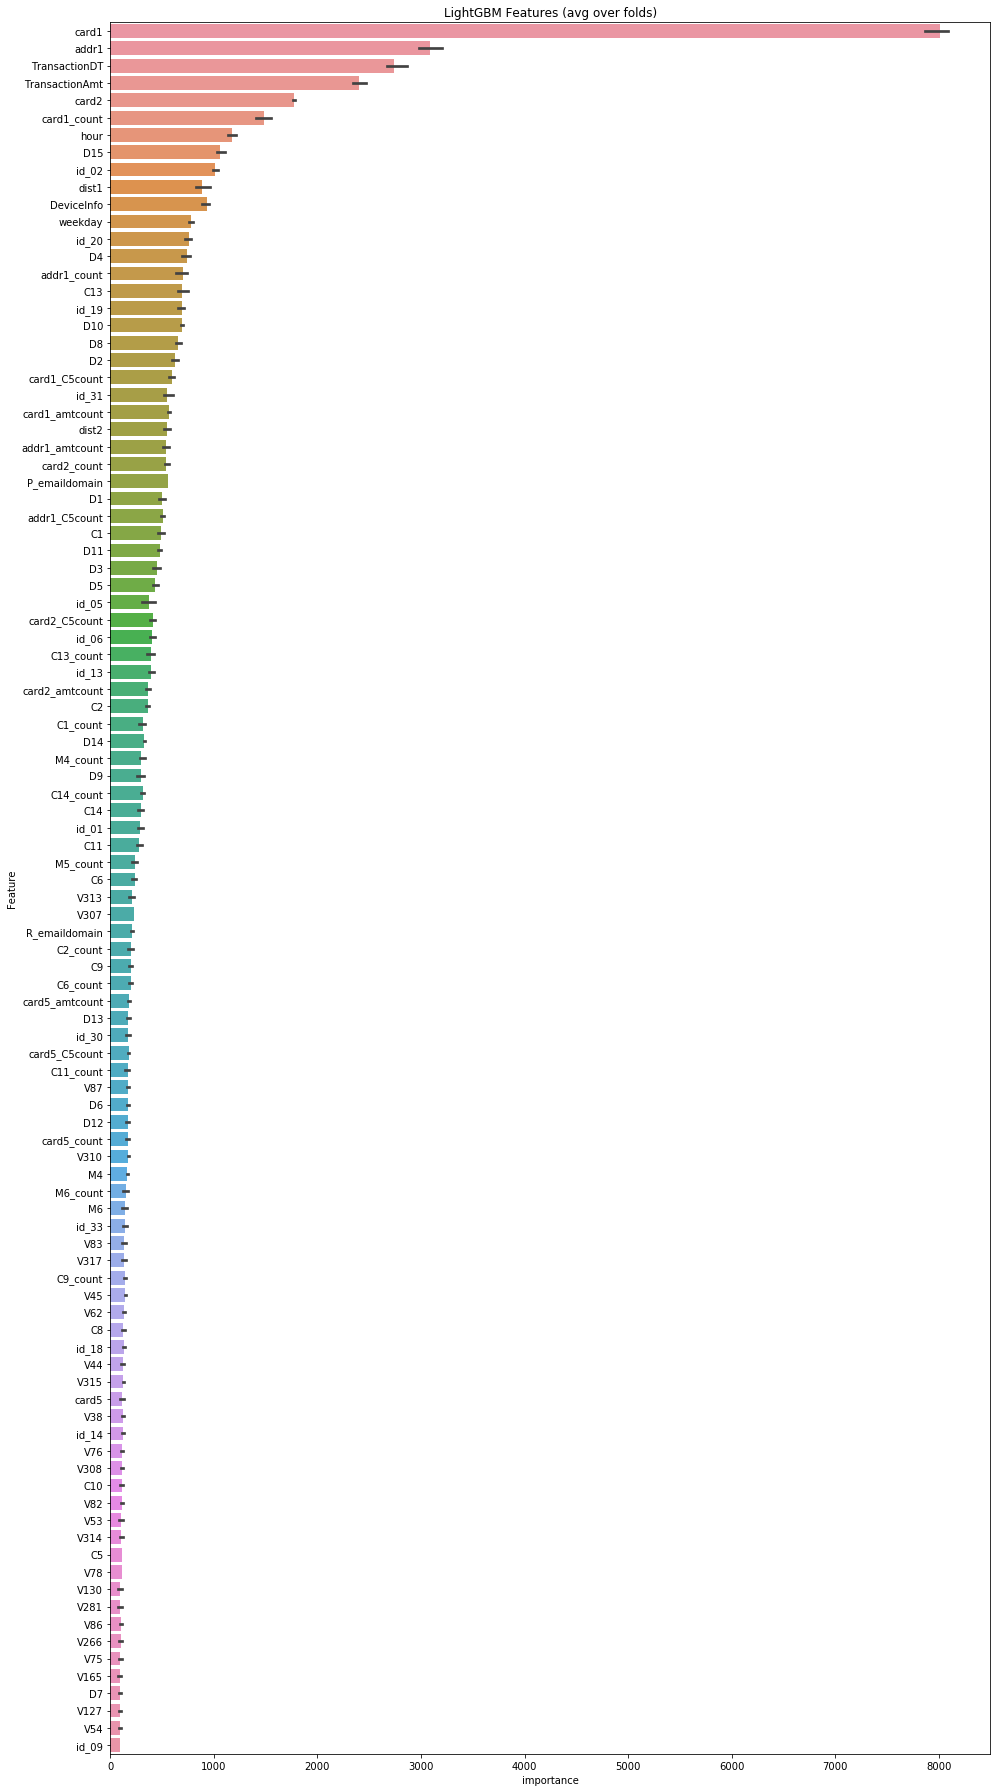

In [14]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100].index)
print(cols)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [15]:
import catboost as cb
from catboost import CatBoostClassifier,Pool
# os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3,4"




cate = [x for x in X_train.columns if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card") or 
                                       x.endswith("domain") or x.startswith("Device")) and not x.endswith("count") ]

# cate = []
print(cate)
verbose_eval = 30
num_rounds = 1000
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds3 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train.iloc[tr_idx, :].fillna(-1), X_train.iloc[val_idx, :].fillna(-1)
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    model=cb.CatBoostClassifier(iterations=num_rounds,depth=11,learning_rate=0.05,loss_function='Logloss',eval_metric='Logloss'
                                ,task_type = "GPU",devices = ["3"])
    model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_vl, y_vl),verbose_eval = 30)
        
    y_pred_train = model.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds3+= model.predict_proba(X_test.fillna(-1))[:,1] / folds
    
    
    if debug:    
        print("debug:",roc_auc_score(y_test, model.predict_proba(X_test.fillna(-1))[:,1] / folds))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33))  

['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo']
0:	learn: 0.6028764	test: 0.6024742	best: 0.6024742 (0)	total: 182ms	remaining: 3m 2s
30:	learn: 0.0876815	test: 0.0812054	best: 0.0812054 (30)	total: 4.72s	remaining: 2m 27s
60:	learn: 0.0681631	test: 0.0620935	best: 0.0620935 (60)	total: 9.52s	remaining: 2m 26s
90:	learn: 0.0622260	test: 0.0571434	best: 0.0571434 (90)	total: 14.2s	remaining: 2m 21s
120:	learn: 0.0592051	test: 0.0547392	best: 0.0547392 (120)	total: 18.7s	remaining: 2m 15s
150:	learn: 0.0571152	test: 0.0531574	best: 0.0531574 (150)	total: 23.2s	remaining: 2m 10s
180:	learn: 0.0555648	test: 0.0521304	best: 0.0521304 (180)	total: 27.7s	remaining: 2m 5s
210:	learn: 0.0542654	test: 0.0513835	best: 0.0513835 (210)	total: 32.2s	remaining: 2m
240:	learn: 0.0531876	test: 0.0507419	best: 0.0507419 (240)	total: 36.7s	remaining: 1m 55s
270:	learn: 0.0522585	test: 0.0502615	best: 0.050

510:	learn: 0.0464394	test: 0.0475737	best: 0.0475737 (510)	total: 1m 18s	remaining: 1m 14s
540:	learn: 0.0457595	test: 0.0472409	best: 0.0472409 (540)	total: 1m 22s	remaining: 1m 10s
570:	learn: 0.0451011	test: 0.0469342	best: 0.0469342 (570)	total: 1m 27s	remaining: 1m 5s
600:	learn: 0.0446083	test: 0.0467460	best: 0.0467460 (600)	total: 1m 31s	remaining: 1m 1s
630:	learn: 0.0441428	test: 0.0465916	best: 0.0465916 (630)	total: 1m 36s	remaining: 56.5s
660:	learn: 0.0436314	test: 0.0463891	best: 0.0463891 (660)	total: 1m 41s	remaining: 51.9s
690:	learn: 0.0430814	test: 0.0461765	best: 0.0461757 (689)	total: 1m 45s	remaining: 47.3s
720:	learn: 0.0425690	test: 0.0459992	best: 0.0459992 (720)	total: 1m 50s	remaining: 42.7s
750:	learn: 0.0420813	test: 0.0458002	best: 0.0458002 (750)	total: 1m 55s	remaining: 38.1s
780:	learn: 0.0413990	test: 0.0454283	best: 0.0454283 (780)	total: 1m 59s	remaining: 33.6s
810:	learn: 0.0409124	test: 0.0451850	best: 0.0451850 (810)	total: 2m 4s	remaining: 29s


In [17]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds))
    print("debug:",roc_auc_score(y_test, y_preds2))
    print("debug:",roc_auc_score(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33))

debug: 0.931190208401744
debug: 0.9217016572481902
debug: 0.9211114266886078
debug: 0.9346170062452758
debug: 0.9375568596158632


In [16]:
sample_submission['isFraud'] = (y_preds + y_preds2 + y_preds3)*0.33
sample_submission.to_csv('simple_ensemble3.csv')


ValueError: Length of values does not match length of index